# 로컬 개발 코드
- 로컬에서 주피터 노트북(Jupyter Notebook), 주피터 랩(JupyterLab) 또는 파이썬(Python)을 이용한다. 
- 사이킷 런(scikit-learn), 텐서플로우(tensorflow), 파이토치(pytorch)를 사용하여 딥러닝 프로그램을 개발한다.
- 파일명: 0_local_text_generation.ipynb

### 로컬 개발 워크플로우(workflow)  
- 로컬 개발 워크플로우를 다음의 4단계로 분리한다.

1. **데이터셋 준비(Data Setup)**
- 로컬 저장소에서 전처리 및 학습에 필요한 학습 데이터셋을 준비한다.

2. **데이터 전처리(Data Preprocessing)**
- 데이터셋의 분석 및 정규화(Normalization)등의 전처리를 수행한다.
- 데이터를 모델 학습에 사용할 수 있도록 가공한다.
- 추론과정에서 필요한 경우, 데이터 전처리에 사용된 객체를 meta_data 폴더 아래에 저장한다.

3. **학습 모델 훈련(Train Model)**
- 데이터를 훈련에 사용할 수 있도록 가공한 뒤에 학습 모델을 구성한다. 
- 학습 모델을 준비된 데이터셋으로 훈련시킨다.
- 정확도(Accuracy)나 손실(Loss)등 학습 모델의 성능을 검증한다.
- 학습 모델의 성능 검증 후, 학습 모델을 배포한다.
- 배포할 학습 모델을 meta_data 폴더 아래에 저장한다.

4. **추론(Inference)**
- 저장된 전처리 객체나 학습 모델 객체를 준비한다.
- 추론에 필요한 테스트 데이터셋을 준비한다.
- 배포된 학습 모델을 통해 테스트 데이터에 대한 추론을 진행한다. 

# 텍스트 생성(Text Generation)
- generate text using a character-based RNN

### 딥러닝을 이용한 텍스트 생성 워크플로우(workflow)
- 1. 셰익스피어 텍스트 파일(shakespeare.txt) 얻기
- 2. 텍스트의 문자를 숫자id로 치환하고 모델의 목적에 맞게 입출력 시퀀스로 변환
- 3. RNN(Recurrent Neural Network)을 통한 텍스트 생성

### 텍스트 생성 RNN기반 모델
- 모델은 캐릭터(문자) 기반입니다. 훈련이 시작되었을 때 모델은 영어 단어의 철자법을 몰랐거나 단어가 텍스트의 단위라는 것도 몰랐습니다.
- 출력 구조는 연극과 유사합니다. 텍스트 블록은 일반적으로 데이터셋과 유사한 모든 대문자로 화자 이름으로 시작합니다.
- 이 모델은 작은 배치의 텍스트(각각 100자)에 대해 학습되며 일관된 구조로 더 긴 텍스트 시퀀스를 생성할 수 있습니다.

In [1]:
# imports
import tensorflow as tf

import numpy as np
import os
import zipfile
from glob import glob

import matplotlib.pyplot as plt

## **1. 데이터셋 준비(Data Setup)**

In [2]:
zip_target_path = './meta_data'
os.makedirs(zip_target_path, exist_ok=True)

In [3]:
# dataset.zip 파일을 dataset 폴더에 압축을 풀어준다.
zip_source_path = './dataset.zip'

extract_zip_file = zipfile.ZipFile(zip_source_path)
extract_zip_file.extractall(zip_target_path)
 
extract_zip_file.close()

In [4]:
path_to_file = os.path.join(zip_target_path, 'dataset/shakespeare.txt')

# 데이터 불러오기
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

In [5]:
# 데이터 확인
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


## **2. 데이터 전처리(Data Preprocessing)**

In [6]:
# 어휘묶음 생성
vocab = sorted(set(text))

# chars를 숫자id로 변경하는 StringLookup layer
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

# 숫자id를 chars로 변경하는 StringLookup layer
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [7]:
# train예제 및 target 만들기
# 각 입력 시퀀스에 대해 해당 대상은 한 문자를 오른쪽으로 이동한 것을 제외하고 동일한 길이의 텍스트를 포함한다.
# 예시 : seq_length는 4이고 텍스트는 "Hello"인 경우
#        입력 시퀀스는 "Hell"이고, target 시퀀스는 "ello"

all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

# 여기서 시퀀스 길이는 100
seq_length = 100
# examples_per_epoch = len(text)//(seq_length+1)

sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [8]:
# 시퀀스를 입력으로 받아 복제하고 입력과 라벨을 정렬하는 함수
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [9]:
# 입력시퀀스에 따른 타겟시퀀스 생성하고 이를 dataset에 저장
dataset = sequences.map(split_input_target)

In [10]:
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

## **3. 학습 모델 훈련(Train Model)**

In [11]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

## 게이트 순환 유닛(Gated Recurrent Unit, GRU)
 - GRU(Gated Recurrent Unit)는 2014년 뉴욕대학교 조경현 교수님이 집필한 논문에서 제안되었습니다.
 - GRU는 LSTM의 장기 의존성 문제에 대한 해결책을 유지하면서, hidden state를 업데이트하는 계산을 줄였습니다.
 - 다시 말해서, GRU는 성능은 LSTM과 유사하면서 복잡했던 LSTM의 구조를 간단화 시켰습니다.
 
### RNN, LSTM, GRU
 * RNN  
 RNN은 이전 타임 스텝에서의 어떠한 정보(hidden state)를 다음 타임스텝으로 계속 전달하여 연산하는 방식입니다.  
 하지만 RNN의 경우 시퀀스가 너무 길다면 앞 쪽의 타임 스텝의 정보가 뒤에 있는 타입스텝까지 충분히 전달되지 못하는 문제가 있습니다.  
 이를 장기 의존성 문제(long-term dependecies)라고 정리했습니다. LSTM과 GRU는 RNN의 이러한 문제점을 개선하고자 나온 모델입니다.  


 * LSTM(Long Short term Memory)  
 LSTM은 hidden state만이 아니라 cell state라는 역할이 있으며 Forget gate, Input gate, Output gate를 통해 계산이 이루어집니다.  
 gate 이름에서 알 수 있듯이 어떤 정보를 잊을지 유지할지를 선택하여 long-term과 short-term에 대한 정보를 고려할 수 있습니다.  
 cell state의 업데이트는 각 gate의 결과를 더함으로써 진행하는데 이는 시퀀스가 길더라도 gradient, 즉 오차를 상대적으로 잘 전파할 수 있도록 합니다.
 
 
 * LSTM과 GRU  
 GRU와 LSTM 중 어떤 것이 모델의 성능면에서 더 낫다라고 단정지어 말할 수 없으며,  
기존에 LSTM을 사용하면서 최적의 하이퍼파라미터를 찾아낸 상황이라면 굳이 GRU로 바꿔서 사용할 필요는 없습니다.  
경험적으로 데이터 양이 적을 때는 매개 변수의 양이 적은 GRU가 조금 더 낫고, 데이터 양이 더 많으면 LSTM이 더 낫다고도 합니다.  
GRU보다 LSTM에 대한 연구나 사용량이 더 많은데, 이는 LSTM이 더 먼저 나온 구조이기 때문입니다.

In [12]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)
    
    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)
    
        if return_state:
            return x, states
        else:
            return x

In [13]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam', loss=loss)

In [14]:
# Directory where the checkpoints will be saved
checkpoint_dir = './meta_data/training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "last_ckpt")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='loss',
    save_best_only=True,
    save_weights_only=True)

In [15]:
EPOCHS = 50

In [16]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/50
172/172 [==============================] - 16s 66ms/step - loss: 2.7251
Epoch 2/50
172/172 [==============================] - 12s 67ms/step - loss: 1.9918
Epoch 3/50
172/172 [==============================] - 12s 66ms/step - loss: 1.7194
Epoch 4/50
172/172 [==============================] - 12s 67ms/step - loss: 1.5575
Epoch 5/50
172/172 [==============================] - 12s 66ms/step - loss: 1.4572
Epoch 6/50
172/172 [==============================] - 12s 66ms/step - loss: 1.3889
Epoch 7/50
172/172 [==============================] - 12s 66ms/step - loss: 1.3368
Epoch 8/50
172/172 [==============================] - 12s 67ms/step - loss: 1.2920
Epoch 9/50
172/172 [==============================] - 12s 66ms/step - loss: 1.2510
Epoch 10/50
172/172 [==============================] - 12s 66ms/step - loss: 1.2127
Epoch 11/50
172/172 [==============================] - 12s 66ms/step - loss: 1.1738
Epoch 12/50
172/172 [==============================] - 12s 66ms/step - loss: 1.1342
E

In [17]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense (Dense)               multiple                  67650     
                                                                 
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


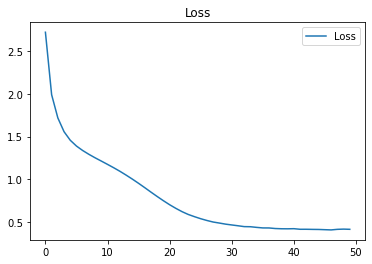

In [18]:
#Plot accuracy and loss curves for both training and validation data
loss = history.history['loss']

plt.plot(loss, label='Loss')
plt.title("Loss")
plt.legend()
plt.show()

## **4. 추론(Inference)**

In [19]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars
    
        # Create a mask to prevent "[UNK]" from being generated.
        skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
        sparse_mask = tf.SparseTensor(
            # Put a -inf at each bad index.
            values=[-float('inf')]*len(skip_ids),
            indices=skip_ids,
            # Match the shape to the vocabulary
            dense_shape=[len(ids_from_chars.get_vocabulary())])
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)
  
    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convert strings to token IDs.
        input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
        input_ids = self.ids_from_chars(input_chars).to_tensor()
    
        # Run the model.
        # predicted_logits.shape is [batch, char, next_char_logits]
        predicted_logits, states = self.model(inputs=input_ids, states=states,
                                              return_state=True)
        # Only use the last prediction.
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits/self.temperature
        # Apply the prediction mask: prevent "[UNK]" from being generated.
        predicted_logits = predicted_logits + self.prediction_mask
        
        # Sample the output logits to generate token IDs.
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)
    
        # Convert from token ids to characters
        predicted_chars = self.chars_from_ids(predicted_ids)
    
        # Return the characters and model state.
        return predicted_chars, states

In [20]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [34]:
zip_test_target_path = './meta_data'
os.makedirs(zip_test_target_path, exist_ok=True)

In [35]:
# test_dataset.zip 파일을 test_dataset 폴더에 압축을 풀어준다.
zip_test_source_path = './test_dataset.zip'

extract_zip_file = zipfile.ZipFile(zip_test_source_path)
extract_zip_file.extractall(zip_test_target_path)

extract_zip_file.close()

In [36]:
# laod test data
test_files = glob(os.path.join(zip_test_target_path, 'test_dataset/*.txt'))

In [37]:
test_data = []
for test_file in test_files:
    with open(test_file, 'r') as f:
        test_data.append(f.read())

In [38]:
def inference(next_char):
    states = None

    result = [next_char]

    for n in range(100):
        next_char, states = one_step_model.generate_one_step(next_char, states=states)
        result.append(next_char)

    return tf.strings.join(result)[0].numpy().decode("utf-8")

In [39]:
for data in test_data:
    print('############ inference ############')
    next_char = tf.constant([data])
    print(inference(next_char), '\n\n')

############ inference ############
ROMEO: My Secial to him.

BUCKINGHAM:
Good awhile the Welshmen, old Lancaster,
Deformed for a piece of beau 


############ inference ############
JULIET: I pray, good friends, Grumio,
Now is the father's name; I have with her child
play to my stads, and  


############ inference ############
ROMEO: I am unrever'd from a weel.

DUKE OF YORK:

HASTINGS:
Good father, child, quick, do you the common,
 


